In [1]:
%cd ../../..

/Users/bezha/PycharmProjects/TripleStreams


In [2]:
import numpy as np
import yaml
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import os
os.environ.pop("MPLDEBUG", None)
import tqdm
import torch
from torch.utils.data import DataLoader
from model import FlexControlTripleStreamsVAE, load_model
from data import get_flexcontrol_triplestream_dataset, FlexControlGroove2TripleStream2BarDataset
from helpers.control_feature_utils import run_inference_and_extract_features, run_inference, extract_control_features

Could not import fluidsynth. AUDIO rendering will not work.
Holoviews not installed. Please install holoviews to be able to generate heatmaps.


In [73]:
import yaml
config = yaml.safe_load(open('eval/Post-Training/ControlConfiguration1/config.yaml', 'r'))

is_testing = True

dataset = get_flexcontrol_triplestream_dataset(
        config=config,
        subset_tag="validation",
        use_cached=True,
        downsampled_size=2000 if is_testing else None,
        print_logs=False                                #<---  Set to True to print dataset loading logs
    )

dataloader = DataLoader(
    dataset,
    batch_size=1024 ,
    shuffle=False,
    num_workers=0
)


In [75]:
from model import load_model_auto
model = load_model(
    model_path='eval/Post-Training/ControlConfiguration1/step_274196.pth',
    model_class=FlexControlTripleStreamsVAE,
    is_evaluating=True
)

✅ Using config from model file
[None] [None, None, None, None, None]
🎉 Successfully loaded FlexControlTripleStreamsVAE


### Objective 1: Does Total Hit Count Work? Does it increase the pattern density?

- Grab samples from the dataset
- Overwrite the Total Hit Count Feature (move it from 0 to 1 in increments of 0.1)
- check if the pattern density increases accordingly

In [76]:
model.eval()

features = {i: [] for i in np.arange(0, 1.01, 0.05)}

with torch.no_grad():
    for t_h_c in tqdm.tqdm(features.keys()):
        for batch in dataloader:
            flat_hvo_groove = batch[0]
            encoding_control_tokens = batch[2]
            decoding_control_tokens = batch[3]

            decoding_control_tokens[:, 0] = t_h_c  # Set Total Hit Count to the current value
            hvo, latent_z = model.predict(
                flat_hvo_groove=batch[0],
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            features[t_h_c].append(hvo.cpu().numpy())

        features[t_h_c] = FlexControlGroove2TripleStream2BarDataset.extract_features_dict(
            {
                "input_hvos": dataset.input_grooves.cpu().numpy(),
                "output_hvos": np.concatenate(features[t_h_c], axis=0),
            },
            normalize=True
        )

100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


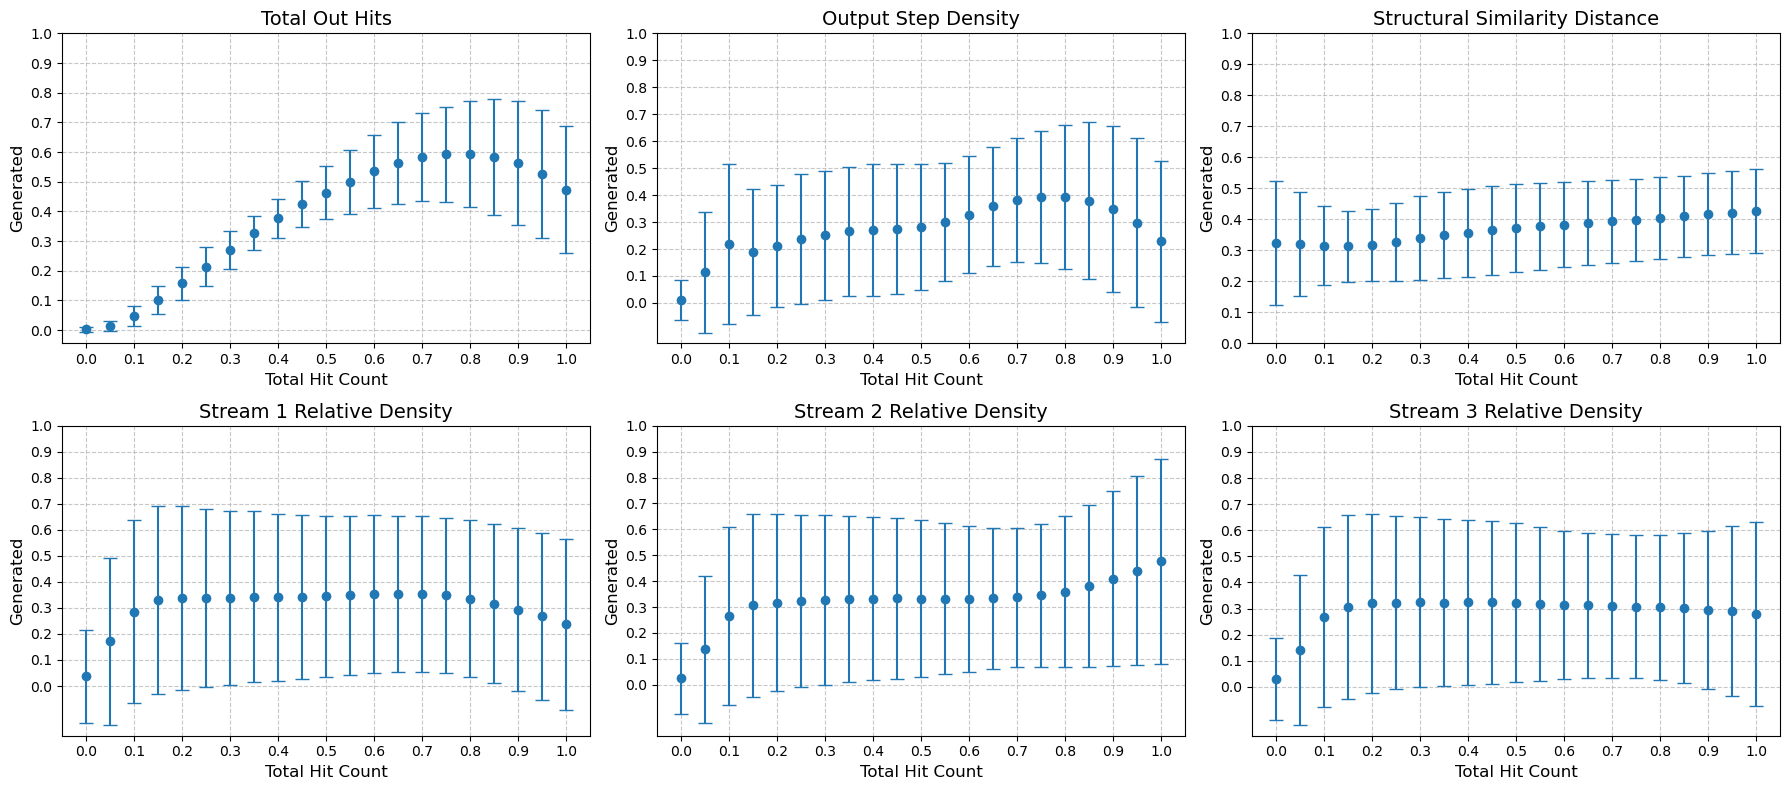

In [77]:
plot_keys = ['Total Out Hits', 'Output Step Density', 'Structural Similarity Distance', 'Stream 1 Relative Density', 'Stream 2 Relative Density', 'Stream 3 Relative Density']

x_axis_label = 'Total Hit Count'

# plot a 1x6 grid of subplots with the keys in plot_keys
plt.figure(figsize=(18, 8))
for i, key in enumerate(plot_keys):
    means = [np.mean(features[t_h_c][key]) for t_h_c in features.keys()]
    stds = [np.std(features[t_h_c][key]) for t_h_c in features.keys()]

    plt.subplot(2, 3, i + 1)
    plt.errorbar(
        list(features.keys()),
        means,
        yerr=stds,
        fmt='o',
        capsize=5,
        label=key
    )
    plt.xlabel(x_axis_label, fontsize=12)
    plt.ylabel('Generated', fontsize=12)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(key, fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eval/Post-Training/ControlConfiguration1/TotalHitCountEffectiveness.png', dpi=300)


Observations:

    - In most cases, the other features stay the same (except for output step density which makes sense)

    - However, total hit doesnt go to max? Why? Maybe because the other controls are limiting the model's ability to generate more active patterns? Let's regenerate: For Total Hit Count >= 0.6, Step Density == 1.0 and Relative Stream Densities 1-3 = 1/3.0 (i.e. assuming all events coincide and are equally distributed. Result! Exactly was the case

In [78]:
model.eval()

features = {i: [] for i in np.arange(0, 1.01, 0.05)}

with torch.no_grad():
    for t_h_c in tqdm.tqdm(features.keys()):
        for batch in dataloader:
            flat_hvo_groove = batch[0]
            encoding_control_tokens = batch[2]
            decoding_control_tokens = batch[3]

            decoding_control_tokens[:, 0] = t_h_c  # Set Total Hit Count to the current value

            if t_h_c >= 0.6:
                decoding_control_tokens[:, 1] = 1.0  # Set Step Density to 1.0
                decoding_control_tokens[:, 2:5] = 1/3.0  # Set Relative Stream Densities to 1/3.0

            hvo, latent_z = model.predict(
                flat_hvo_groove=batch[0],
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            features[t_h_c].append(hvo.cpu().numpy())

        features[t_h_c] = FlexControlGroove2TripleStream2BarDataset.extract_features_dict(
            {
                "input_hvos": dataset.input_grooves.cpu().numpy(),
                "output_hvos": np.concatenate(features[t_h_c], axis=0),
            },
            normalize=True
        )


100%|██████████| 21/21 [00:49<00:00,  2.35s/it]


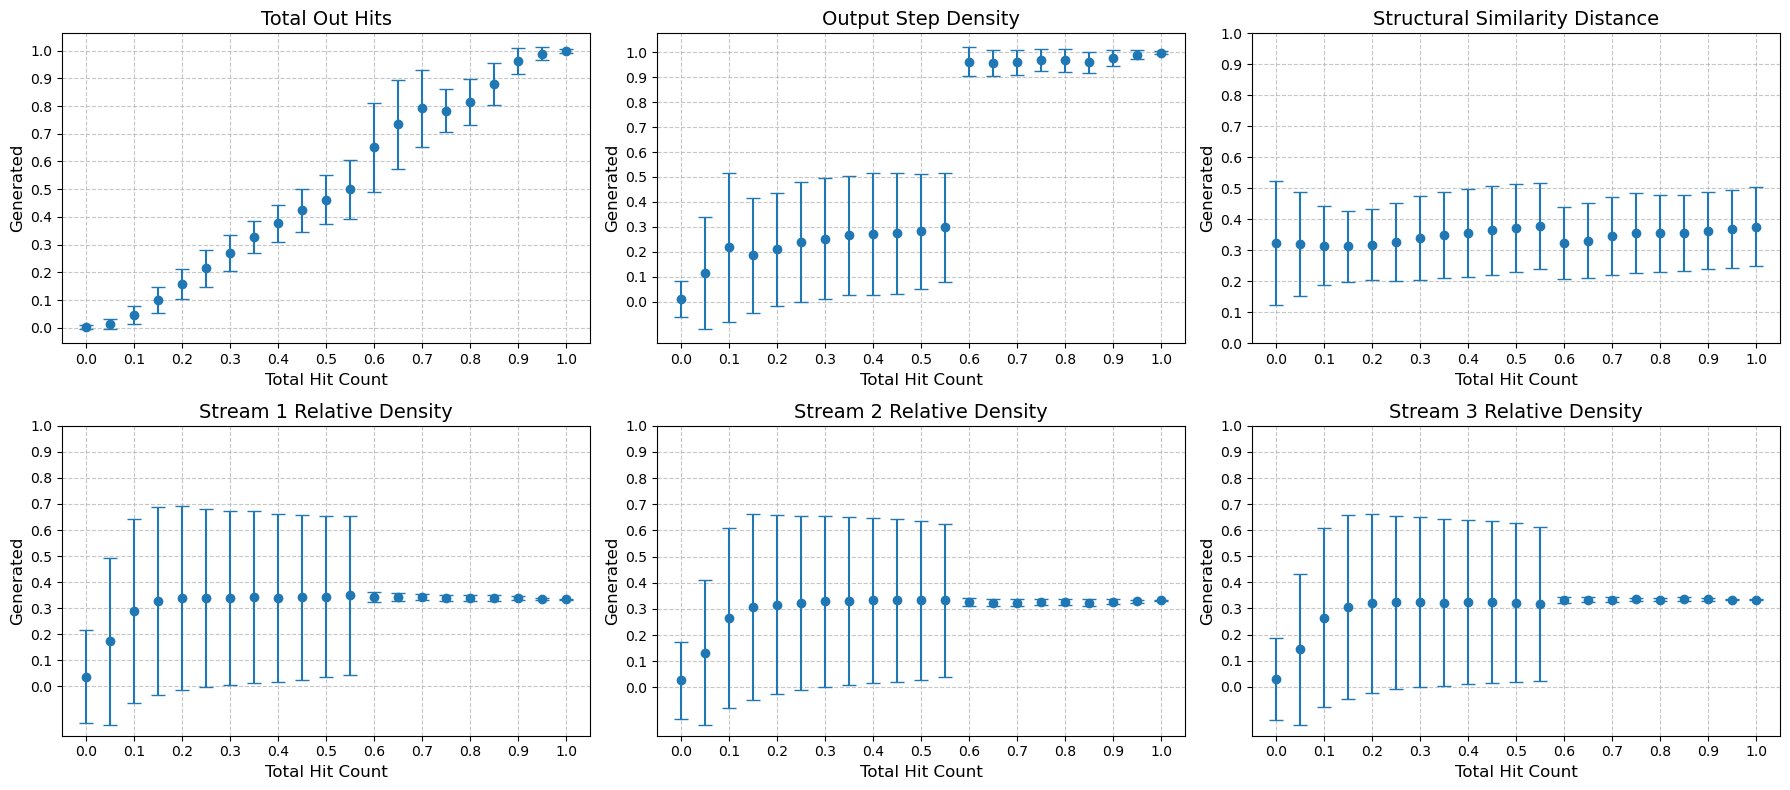

In [79]:
plot_keys = ['Total Out Hits', 'Output Step Density', 'Structural Similarity Distance', 'Stream 1 Relative Density', 'Stream 2 Relative Density', 'Stream 3 Relative Density']

x_axis_label = 'Total Hit Count'

# plot a 1x6 grid of subplots with the keys in plot_keys
plt.figure(figsize=(18, 8))
for i, key in enumerate(plot_keys):
    means = [np.mean(features[t_h_c][key]) for t_h_c in features.keys()]
    stds = [np.std(features[t_h_c][key]) for t_h_c in features.keys()]

    plt.subplot(2, 3, i + 1)
    plt.errorbar(
        list(features.keys()),
        means,
        yerr=stds,
        fmt='o',
        capsize=5,
        label=key
    )
    plt.xlabel(x_axis_label, fontsize=12)
    plt.ylabel('Generated', fontsize=12)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(key, fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eval/Post-Training/ControlConfiguration1/TotalHitCountEffectiveness.png', dpi=300)


### Now let's do the same, but see how much change will occur in the features for the same pattern at different Total Hit Count values

In [80]:
model.eval()

features = {i: [] for i in np.arange(0, 1.01, 0.2)}

with torch.no_grad():
    for t_h_c in tqdm.tqdm(features.keys()):
        for batch in dataloader:
            flat_hvo_groove = batch[0]

            encoding_control_tokens = batch[2]
            decoding_control_tokens = batch[3]

            decoding_control_tokens[:, 0] = t_h_c  # Set Total Hit Count to the current value

            hvo, latent_z = model.predict(
                flat_hvo_groove=batch[0],
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            features[t_h_c].append(hvo.cpu().numpy())

        features[t_h_c] = FlexControlGroove2TripleStream2BarDataset.extract_features_dict(
            {
                "input_hvos": dataset.input_grooves.cpu().numpy(),
                "output_hvos": np.concatenate(features[t_h_c], axis=0),
            },
            normalize=True
        )

100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


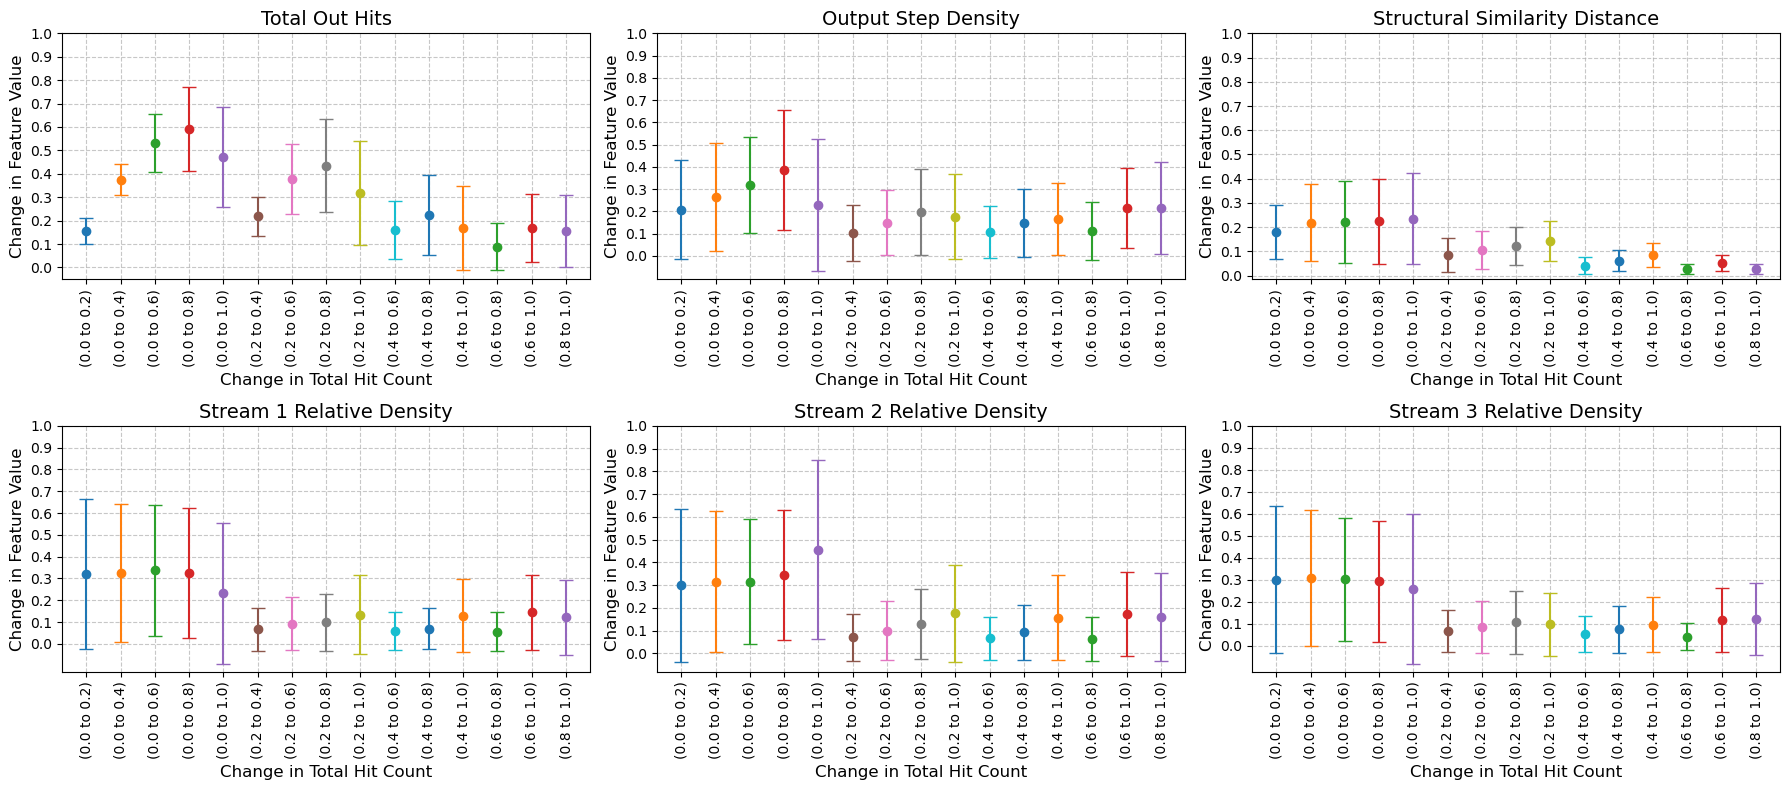

In [81]:
import itertools
# get all possible permutations of feature keys
value_pairs = list(itertools.combinations(features.keys(), 2))

plot_keys = ['Total Out Hits', 'Output Step Density', 'Structural Similarity Distance', 'Stream 1 Relative Density', 'Stream 2 Relative Density', 'Stream 3 Relative Density']

x_axis_label = 'Change in Total Hit Count'

# plot a 1x6 grid of subplots with the keys in plot_keys
plt.figure(figsize=(18, 8))
for i, key in enumerate(plot_keys):
    cnt = 0
    plt.subplot(2, 3, i + 1)
    for pair in value_pairs:
        t_h_c1, t_h_c2 = pair
        val1 = np.array(features[t_h_c1][key])
        val2 = np.array(features[t_h_c2][key])
        change = np.abs(val2 - val1)
        # plot mean and std
        plt.errorbar(
            cnt,
            np.mean(change),
            yerr=np.std(change),
            fmt='o',
            capsize=5,
            label=f'{t_h_c1} to {t_h_c2})'
        )

        cnt += 1

    plt.xlabel(x_axis_label, fontsize=12)
    plt.ylabel('Change in Feature Value', fontsize=12)
    plt.xticks(np.arange(0, cnt, 1), labels=[f'({np.round(pair[0], 1)} to {np.round(pair[1], 1)})' for pair in value_pairs], rotation=90)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(key, fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('eval/Post-Training/ControlConfiguration1/TotalHitCountChange.png', dpi=300)


### Objective 2: Does Step Density Count Work? Does it increase step density?

let's do the same analysis, instead this time we use GT values for all features except that we will increase Step density from 0 to 1

In [82]:
model.eval()

features = {i: [] for i in np.arange(0, 1.01, 0.05)}

with torch.no_grad():
    for t_h_c in tqdm.tqdm(features.keys()):
        for batch in dataloader:
            flat_hvo_groove = batch[0]
            encoding_control_tokens = batch[2]
            decoding_control_tokens = batch[3]

            decoding_control_tokens[:, 1] = t_h_c  # Set Total Hit Count to the current value

            hvo, latent_z = model.predict(
                flat_hvo_groove=batch[0],
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            features[t_h_c].append(hvo.cpu().numpy())

        features[t_h_c] = FlexControlGroove2TripleStream2BarDataset.extract_features_dict(
            {
                "input_hvos": dataset.input_grooves.cpu().numpy(),
                "output_hvos": np.concatenate(features[t_h_c], axis=0),
            },
            normalize=True
        )


100%|██████████| 21/21 [00:47<00:00,  2.28s/it]


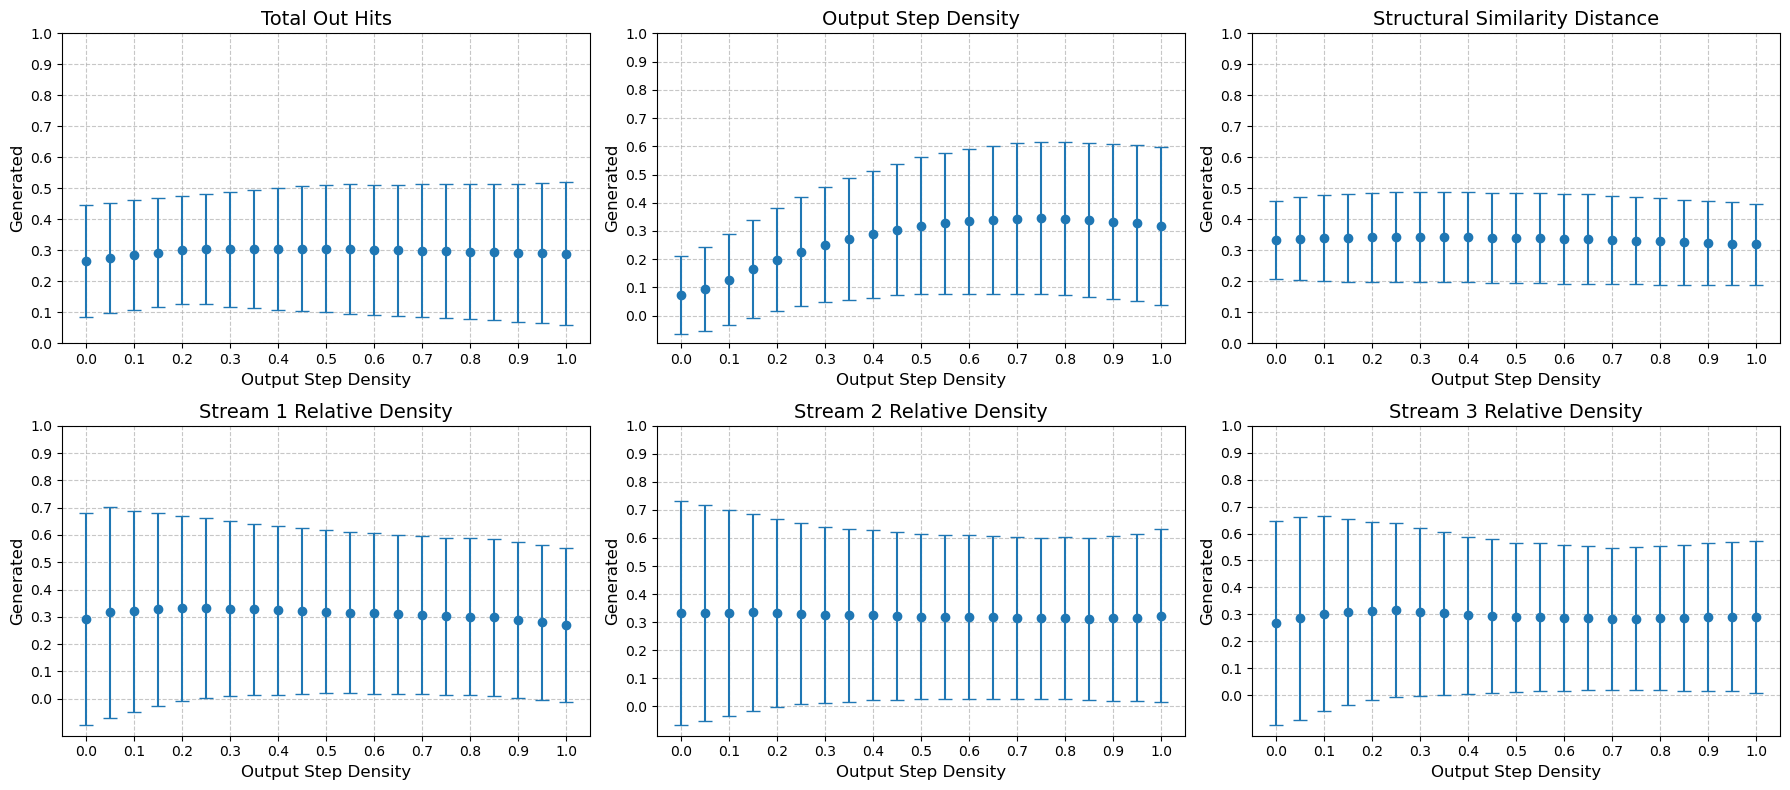

In [83]:
plot_keys = ['Total Out Hits', 'Output Step Density', 'Structural Similarity Distance', 'Stream 1 Relative Density', 'Stream 2 Relative Density', 'Stream 3 Relative Density']

x_axis_label = 'Output Step Density'

# plot a 1x6 grid of subplots with the keys in plot_keys
plt.figure(figsize=(18, 8))
for i, key in enumerate(plot_keys):
    means = [np.mean(features[t_h_c][key]) for t_h_c in features.keys()]
    stds = [np.std(features[t_h_c][key]) for t_h_c in features.keys()]

    plt.subplot(2, 3, i + 1)
    plt.errorbar(
        list(features.keys()),
        means,
        yerr=stds,
        fmt='o',
        capsize=5,
        label=key
    )
    plt.xlabel(x_axis_label, fontsize=12)
    plt.ylabel('Generated', fontsize=12)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(key, fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eval/Post-Training/ControlConfiguration1/TotalHitCountEffectiveness.png', dpi=300)


In [84]:
# now changes

### Objective 3: Do Relative Stream Densities Work?

let's do the same analysis, instead this time we use GT values for all features except that we will increase Relative Stream 1 Densities from 0 to 1.




In [85]:
model.eval()

features = {i: [] for i in np.arange(0, 1.01, 0.05)}

with torch.no_grad():
    for t_h_c in tqdm.tqdm(features.keys()):
        for batch in dataloader:
            flat_hvo_groove = batch[0]
            encoding_control_tokens = batch[2]
            decoding_control_tokens = batch[3]

            decoding_control_tokens[:, 2] = t_h_c  # Set Total Hit Count to the current value

            hvo, latent_z = model.predict(
                flat_hvo_groove=batch[0],
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            features[t_h_c].append(hvo.cpu().numpy())

        features[t_h_c] = FlexControlGroove2TripleStream2BarDataset.extract_features_dict(
            {
                "input_hvos": dataset.input_grooves.cpu().numpy(),
                "output_hvos": np.concatenate(features[t_h_c], axis=0),
            },
            normalize=True
        )


100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


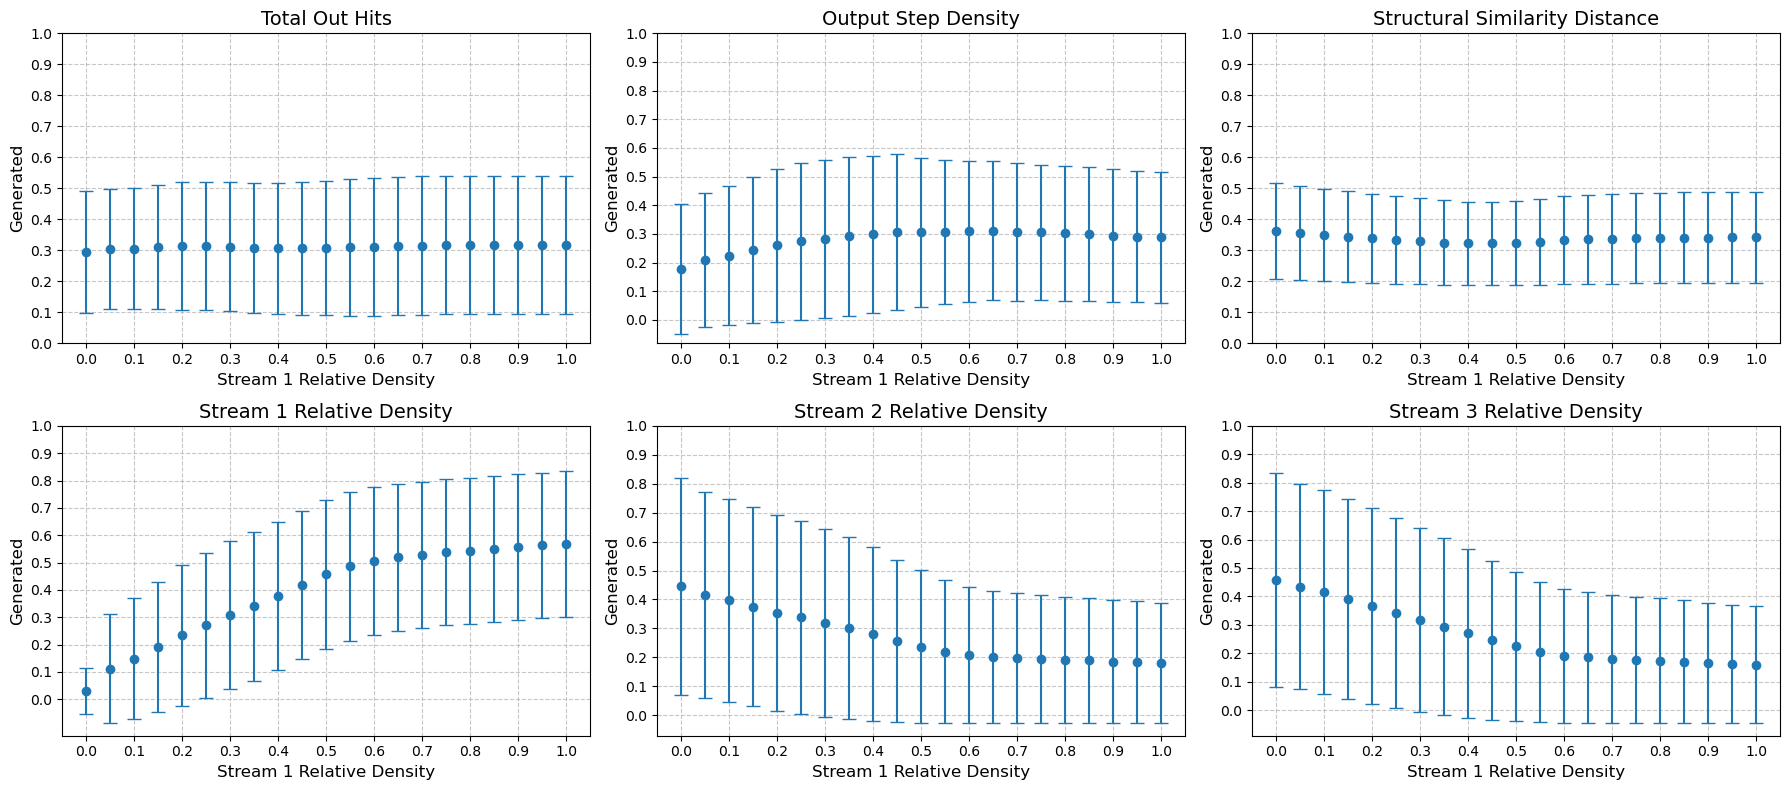

In [86]:
plot_keys = ['Total Out Hits', 'Output Step Density', 'Structural Similarity Distance', 'Stream 1 Relative Density', 'Stream 2 Relative Density', 'Stream 3 Relative Density']

x_axis_label = 'Stream 1 Relative Density'

# plot a 1x6 grid of subplots with the keys in plot_keys
plt.figure(figsize=(18, 8))
for i, key in enumerate(plot_keys):
    means = [np.mean(features[t_h_c][key]) for t_h_c in features.keys()]
    stds = [np.std(features[t_h_c][key]) for t_h_c in features.keys()]

    plt.subplot(2, 3, i + 1)
    plt.errorbar(
        list(features.keys()),
        means,
        yerr=stds,
        fmt='o',
        capsize=5,
        label=key
    )
    plt.xlabel(x_axis_label, fontsize=12)
    plt.ylabel('Generated', fontsize=12)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(key, fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eval/Post-Training/ControlConfiguration1/TotalHitCountEffectiveness.png', dpi=300)


Now using more realistic values for Relative Stream 2 and 3 Densities, i.e. (1 - Relative Stream 1 Density) / 2

In [87]:
model.eval()

features = {i: [] for i in np.arange(0, 1.01, 0.05)}

with torch.no_grad():
    for t_h_c in tqdm.tqdm(features.keys()):
        for batch in dataloader:
            flat_hvo_groove = batch[0]
            encoding_control_tokens = batch[2]
            decoding_control_tokens = batch[3]

            decoding_control_tokens[:, 2] = t_h_c
            decoding_control_tokens[:, 3] = (1.0 - t_h_c) / 2.0  # Set Relative Stream 2 Density to (1 - Relative Stream 1 Density) / 2
            decoding_control_tokens[:, 4] = (1.0 - t_h_c) / 2.0  # Set Relative Stream 3 Density to (1 - Relative Stream 1 Density) / 2

            hvo, latent_z = model.predict(
                flat_hvo_groove=batch[0],
                encoding_control_tokens=encoding_control_tokens,
                decoding_control_tokens=decoding_control_tokens,
            )
            features[t_h_c].append(hvo.cpu().numpy())

        features[t_h_c] = FlexControlGroove2TripleStream2BarDataset.extract_features_dict(
            {
                "input_hvos": dataset.input_grooves.cpu().numpy(),
                "output_hvos": np.concatenate(features[t_h_c], axis=0),
            },
            normalize=True
        )

100%|██████████| 21/21 [00:49<00:00,  2.34s/it]


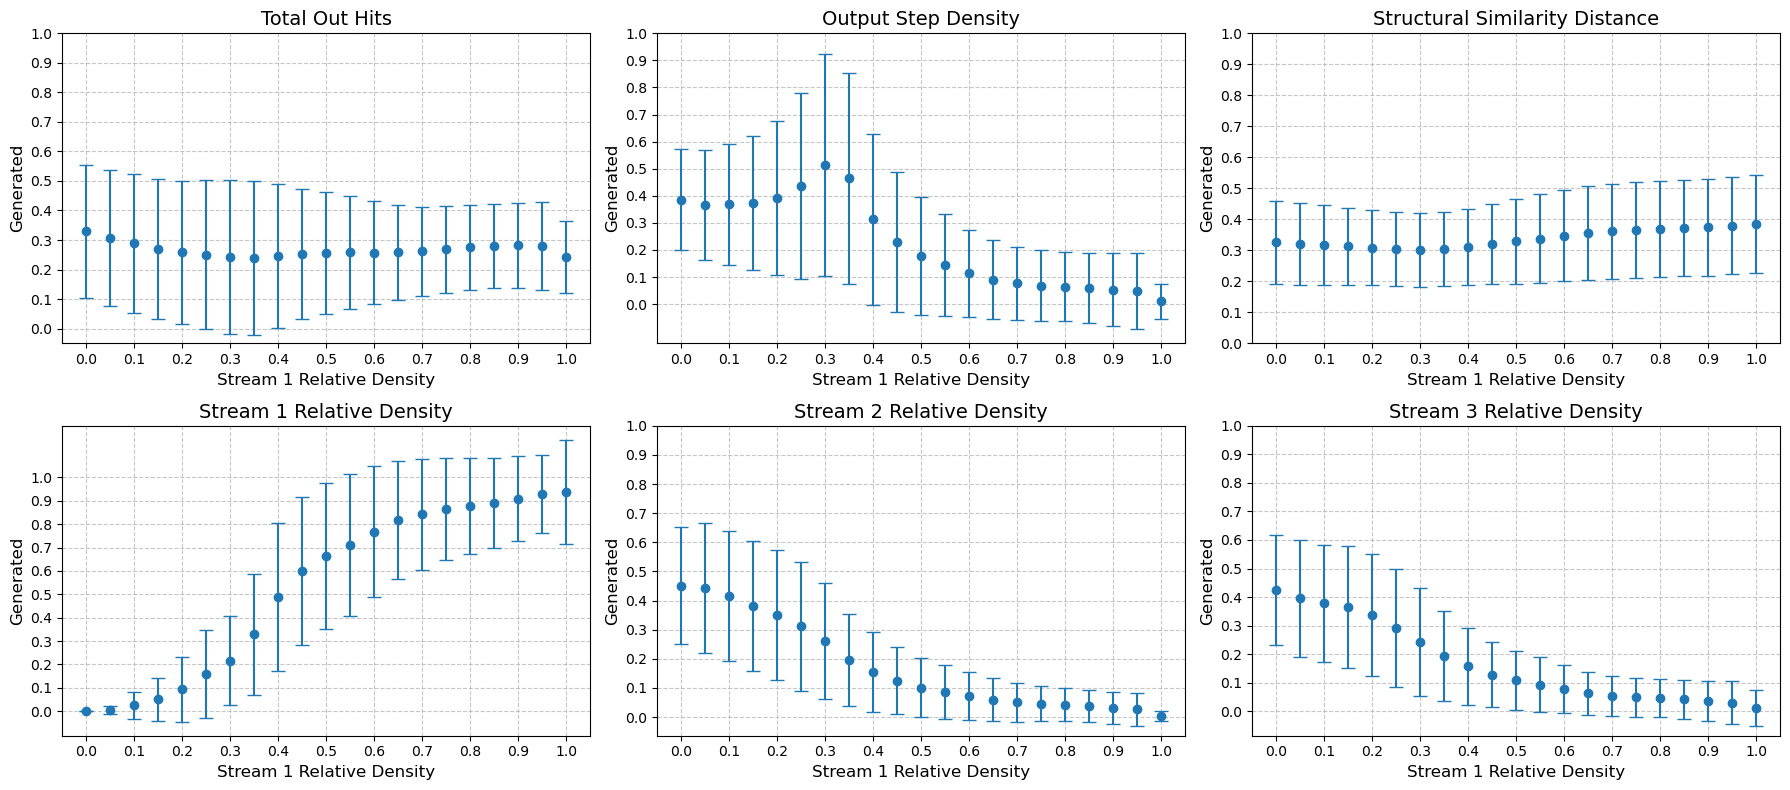

In [88]:
plot_keys = ['Total Out Hits', 'Output Step Density', 'Structural Similarity Distance', 'Stream 1 Relative Density', 'Stream 2 Relative Density', 'Stream 3 Relative Density']

x_axis_label = 'Stream 1 Relative Density'

# plot a 1x6 grid of subplots with the keys in plot_keys
plt.figure(figsize=(18, 8))
for i, key in enumerate(plot_keys):
    means = [np.mean(features[t_h_c][key]) for t_h_c in features.keys()]
    stds = [np.std(features[t_h_c][key]) for t_h_c in features.keys()]

    plt.subplot(2, 3, i + 1)
    plt.errorbar(
        list(features.keys()),
        means,
        yerr=stds,
        fmt='o',
        capsize=5,
        label=key
    )
    plt.xlabel(x_axis_label, fontsize=12)
    plt.ylabel('Generated', fontsize=12)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(key, fontsize=14)
    plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eval/Post-Training/ControlConfiguration1/TotalHitCountEffectiveness.png', dpi=300)


In [89]:
from scipy.stats import wasserstein_distance

# select a random sample from the dataset
# and compare the input groove and the output groove
rand_ix = np.random.randint(0, len(dataset.input_grooves))
groove_1_h = dataset.input_grooves[rand_ix,  :, 0]
groove_2_h = dataset.flat_output_streams[rand_ix,  :, 0]
groove_1_v = dataset.input_grooves[rand_ix, :, 1]
groove_2_v = dataset.flat_output_streams[rand_ix, :, 1]
groove_1_ut = dataset.input_grooves[rand_ix,  :, 2]
groove_2_ut = dataset.flat_output_streams[rand_ix,  :, 0]

groove_2 = dataset.flat_output_streams[rand_ix,  :, 1]

distance = wasserstein_distance(groove_1_v, groove_2_v), wasserstein_distance(groove_1_h, groove_2_h), wasserstein_distance(groove_1_ut, groove_2_ut)
distance

(0.27485236525535583, 0.09375, 0.8901562500977889)

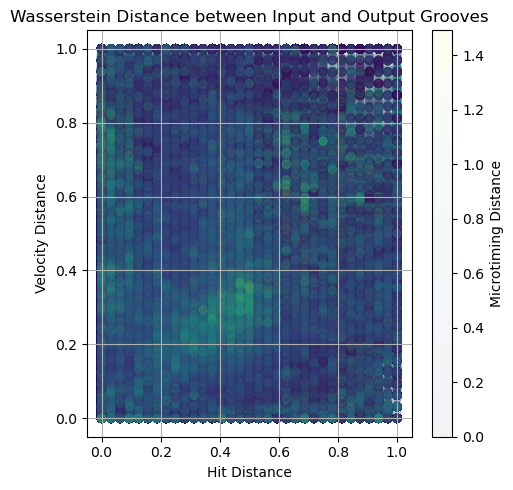

In [70]:
wass_hits = []
wass_vels = []
wass_uts = []

for i in range(len(dataset.input_grooves)):
    wass_hits.append(wasserstein_distance(dataset.input_grooves[i, :, 0], dataset.output_streams[i, :, 0]))
    wass_vels.append(wasserstein_distance(dataset.input_grooves[i, :, 1], dataset.output_streams[i, :, 1]))
    wass_uts.append(wasserstein_distance(dataset.input_grooves[i, :, 2], dataset.output_streams[i, :, 2]))

# plot Hit vs velocity and use microtiming as color
plt.figure(figsize=(5, 5))
plt.scatter(wass_hits, wass_vels, c=wass_uts, cmap='viridis', alpha=0.05)
plt.colorbar(label='Microtiming Distance')
plt.xlabel('Hit Distance')
plt.ylabel('Velocity Distance')
plt.title('Wasserstein Distance between Input and Output Grooves')
plt.grid(True)
plt.tight_layout()
plt.show()

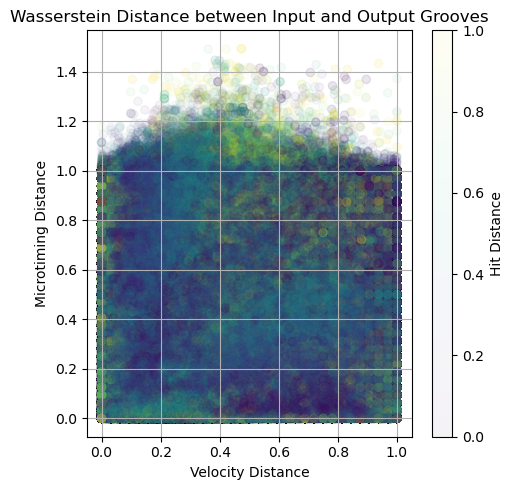

In [71]:
# now vel and micro and hit as color
plt.figure(figsize=(5, 5))
plt.scatter(wass_vels, wass_uts, c=wass_hits, cmap='viridis', alpha=0.05)
plt.colorbar(label='Hit Distance')
plt.xlabel('Velocity Distance')
plt.ylabel('Microtiming Distance')
plt.title('Wasserstein Distance between Input and Output Grooves')
plt.grid(True)
plt.tight_layout()
plt.show()

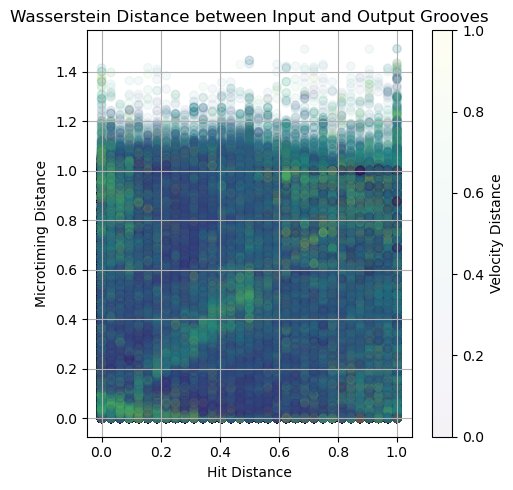

In [72]:

# now hit and micro and vel as color
plt.figure(figsize=(5, 5))
plt.scatter(wass_hits, wass_uts, c=wass_vels, cmap='viridis', alpha=0.05)
plt.colorbar(label='Velocity Distance')
plt.xlabel('Hit Distance')
plt.ylabel('Microtiming Distance')
plt.title('Wasserstein Distance between Input and Output Grooves')
plt.grid(True)
plt.tight_layout()

